## 3.4 Comparison between AWC and ATC DGDs

In this section we compare the pros and cons between AWC and ATC DGDs.

### 3.4.1 Convergence comparison

There are two major differences in convergence performance between AWC and ATC.

#### 3.4.1.1 Limiting Bias.

From Sec.3.2 and Sec.3.3, we know that 

\begin{align}
\lim_{k\to\infty} \frac{1}{n}\sum_{i=1}^n \|x_i^{(k)} - x^\star\|^2 &= O\big( \frac{\alpha^2 \rho^2 b^2}{(1-\rho)^2} \big) \hspace{1cm} \mbox{(ATC-DGD)} \\
\lim_{k\to\infty} \frac{1}{n}\sum_{i=1}^n \|x_i^{(k)} - x^\star\|^2 &= O\big( \frac{\alpha^2 b^2}{(1-\rho)^2} \big) \hspace{1cm} \mbox{(AWC-DGD)}
\end{align}

It is observed that ATC-DGD has an imporved limiting bias given the same step-size $\alpha$ because $\rho < 1$.

#### 3.4.1.2 Step-size range

It is established in literatures \[Refs\] that ATC-DGD can converge if $\alpha \le \frac{2}{L}$ in which $L$ is the Lipschitz constant of each local gradient $\nabla f_i(x)$. However, it is established in \[Refs\] that AWC-DGD can converge if $\alpha \le \frac{1+\lambda_n(W)}{L}$ in which $\lambda_n(W) \in (-1,1)$ is the smallest eigenvalue of the combination matrix $W$. Apparently, AWC-DGD have a narrow step-size ranges to guarantee convergence.

### 3.4.2 Compare convergence performance with BlueFog

In this section we focus on the distributed least square problem and compare the performance of ATC and AWC with BlueFog. For the details of least square problem, see Sec.3.2 and 3.3.

#### 3.4.2.1 Set up BlueFog

In the following code, you should be able to see the id of your CPUs. We use 8 CPUs to conduct the following experiment.

In [2]:
import ipyparallel as ipp

rc = ipp.Client(profile='bluefog')
rc.ids

[0, 1, 2, 3, 4, 5, 6, 7]

Let each agent import necessary modules and then initialize BlueFog. You should be able to see the printed information like:  

> \[stdout:0\] Hello, I am 1 among 8 processes
> 
> ...

In [3]:
%%px
import numpy as np
import bluefog.torch as bf
import torch
from bluefog.common import topology_util
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

bf.init()
print(f"Hello, I am {bf.rank()} among {bf.size()} processes")

[stdout:0] Hello, I am 7 among 8 processes
[stdout:1] Hello, I am 6 among 8 processes
[stdout:2] Hello, I am 4 among 8 processes
[stdout:3] Hello, I am 2 among 8 processes
[stdout:4] Hello, I am 1 among 8 processes
[stdout:5] Hello, I am 5 among 8 processes
[stdout:6] Hello, I am 3 among 8 processes
[stdout:7] Hello, I am 0 among 8 processes


Push seed to each agent so that the simulation can be reproduced.

In [4]:
dview = rc[:] # A DirectView of all engines
dview.block=True

# Push the data into all workers
dview.push({'seed': 2021}, block=True)

[None, None, None, None, None, None, None, None]

After running the following code, you should be able to see the printed information like 

> \[stdout:0\] I received seed as value:  2021
> 
> ...

In [5]:
%%px
print("I received seed as value: ", seed)

[stdout:0] I received seed as value:  2021
[stdout:1] I received seed as value:  2021
[stdout:2] I received seed as value:  2021
[stdout:3] I received seed as value:  2021
[stdout:4] I received seed as value:  2021
[stdout:5] I received seed as value:  2021
[stdout:6] I received seed as value:  2021
[stdout:7] I received seed as value:  2021


Congratulations! Your BlueFog is initialized and tested successfully.

#### 3.4.2.2 Generate local data $A_i$ and $b_i$

In [6]:
%%px

def generate_data(m, n, x_o):
    
    A = torch.randn(m, n).to(torch.double)
    ns = 0.1*torch.randn(m, 1).to(torch.double)
    b = A.mm(x_o) + ns
        
    return A, b

#### 3.4.2.3 Distributed gradient descent method

In [7]:
%%px

def distributed_grad_descent(A, b, maxite=5000, alpha=1e-1):

    x_opt = torch.zeros(n, 1, dtype=torch.double)

    for _ in range(maxite):
        # calculate local gradient 
        grad_local = A.t().mm(A.mm(x_opt) - b)
        
        # global gradient
        grad = bf.allreduce(grad_local, name='gradient')

        # distributed gradient descent
        x_opt = x_opt - alpha*grad

    grad_local = A.t().mm(A.mm(x_opt) - b)
    grad = bf.allreduce(grad_local, name='gradient')  # global gradient

    # evaluate the convergence of distributed gradient descent
    # the norm of global gradient is expected to 0 (optimality condition)
    global_grad_norm = torch.norm(grad, p=2)
    if bf.rank() == 0:
        print("[Distributed Grad Descent] Rank {}: global gradient norm: {}".format(bf.rank(), global_grad_norm))

    return x_opt

In the following code we run distributed gradient descent to achieve the global solution $x^\star$ to the optimization problem. To validate whether $x^\star$ is optimal, it is enough to examine $\frac{1}{n}\sum_{i=1}^n \nabla f_i(x^\star) = 0$.

In [10]:
%%px

m, n = 20, 5
x_o = torch.randn(n, 1).to(torch.double)
x_o = bf.allreduce(x_o, name='x_o') # synchronize the global reference point
A, b = generate_data(m, n, x_o)
x_opt = distributed_grad_descent(A, b, maxite=500, alpha=1e-2)

[stdout:7] [Distributed Grad Descent] Rank 0: global gradient norm: 4.450207821573741e-15


#### 3.4.2.4 AWC-DGD

In [11]:
%%px 

def AWC_DGD_one_step(x, x_opt, A, b, alpha=1e-2):
    
    # one-step ATC-DGD. 
    # The combination weights have been determined by the associated combination matrix.
    
    grad_local = A.t().mm(A.mm(x) - b)                       # compute local grad
    x_new = bf.neighbor_allreduce(x) - alpha*grad_local      # AWC update
    
    # the relative error: |x^k-x_gloval_average|/|x_gloval_average|
    rel_error = torch.norm(x_new-x_opt, p=2)/torch.norm(x_opt,p=2)

    return x_new, rel_error

#### 3.4.2.5 ATC-DGD

In [12]:
%%px 

def ATC_DGD_one_step(x, x_opt, A, b, alpha=1e-2):
    
    # one-step ATC-DGD. 
    # The combination weights have been determined by the associated combination matrix.
    
    grad_local = A.t().mm(A.mm(x) - b)      # compute local grad
    y = x - alpha*grad_local                # adapte
    x_new = bf.neighbor_allreduce(y)        # combination
    
    # the relative error: |x^k-x_gloval_average|/|x_gloval_average|
    rel_error = torch.norm(x_new-x_opt, p=2)/torch.norm(x_opt,p=2)

    return x_new, rel_error

#### 3.4.2.6 Limiting bias comparison between AWC and ATC

In [13]:
%%px

# Set topology as exponential-two topology.
G = topology_util.ExponentialTwoGraph(bf.size())
bf.set_topology(G)

maxite = 300

x_awc = torch.zeros(n, 1, dtype=torch.double)     # Initialize x
rel_error_awc = torch.zeros((maxite, 1))

x_atc = torch.zeros(n, 1, dtype=torch.double)     # Initialize x
rel_error_atc = torch.zeros((maxite, 1))

for ite in range(maxite):
    
    if bf.rank()==0:
        if ite%10 == 0:
            print('Progress {}/{}'.format(ite, maxite))
        
    x_awc, rel_error_awc[ite] = AWC_DGD_one_step(x_awc, x_opt, A, b, alpha=2e-3) # you can adjust alpha to different values
    x_atc, rel_error_atc[ite] = ATC_DGD_one_step(x_atc, x_opt, A, b, alpha=2e-3) # you can adjust alpha to different values
    

[stdout:7] 
Progress 0/300
Progress 10/300
Progress 20/300
Progress 30/300
Progress 40/300
Progress 50/300
Progress 60/300
Progress 70/300
Progress 80/300
Progress 90/300
Progress 100/300
Progress 110/300
Progress 120/300
Progress 130/300
Progress 140/300
Progress 150/300
Progress 160/300
Progress 170/300
Progress 180/300
Progress 190/300
Progress 200/300
Progress 210/300
Progress 220/300
Progress 230/300
Progress 240/300
Progress 250/300
Progress 260/300
Progress 270/300
Progress 280/300
Progress 290/300


In [14]:
rel_error_awc_exp2 = dview.pull('rel_error_awc', block=True, targets=0)
rel_error_atc_exp2 = dview.pull('rel_error_atc', block=True, targets=0)

Text(0, 0.5, 'Relative error')

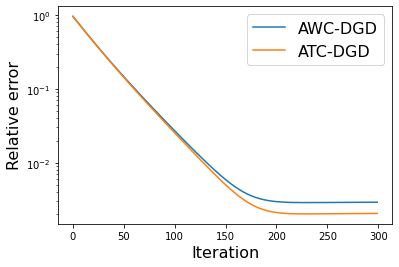

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.semilogy(rel_error_awc_exp2)
plt.semilogy(rel_error_atc_exp2)

plt.legend(['AWC-DGD', 'ATC-DGD'], fontsize=16)

plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Relative error', fontsize=16)

With the same step-size 2e-3, it is observed that ATC-DGD has smaller limiting bias than AWC-DGD, which is consistent with the conclusion in Sec.3.4.1.1.

#### 3.4.2.7 Step-size stability range comparison

In [19]:
%%px

# Set topology as exponential-two topology.
G = topology_util.ExponentialTwoGraph(bf.size())
bf.set_topology(G)

maxite = 20

x_awc = torch.zeros(n, 1, dtype=torch.double)     # Initialize x
rel_error_awc = torch.zeros((maxite, 1))

x_atc = torch.zeros(n, 1, dtype=torch.double)     # Initialize x
rel_error_atc = torch.zeros((maxite, 1))

for ite in range(maxite):
    
    if bf.rank()==0:
        if ite%10 == 0:
            print('Progress {}/{}'.format(ite, maxite))
        
    x_awc, rel_error_awc[ite] = AWC_DGD_one_step(x_awc, x_opt, A, b, alpha=3e-2) # you can adjust alpha to different values
    x_atc, rel_error_atc[ite] = ATC_DGD_one_step(x_atc, x_opt, A, b, alpha=3e-2) # you can adjust alpha to different values
    

[stdout:7] 
Progress 0/20
Progress 10/20


In [20]:
rel_error_awc_exp2 = dview.pull('rel_error_awc', block=True, targets=0)
rel_error_atc_exp2 = dview.pull('rel_error_atc', block=True, targets=0)

Text(0, 0.5, 'Relative error')

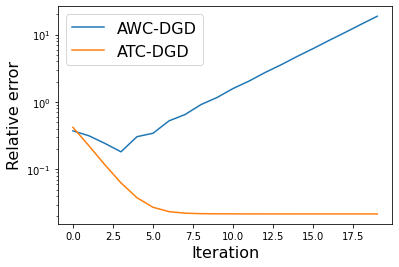

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.semilogy(rel_error_awc_exp2)
plt.semilogy(rel_error_atc_exp2)

plt.legend(['AWC-DGD', 'ATC-DGD'], fontsize=16)

plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Relative error', fontsize=16)

With the same step-size 3e-2, it is observed that AWC diverges but ATC still converges, which is consistent with the conclusion in Sec.3.4.1.1.

### 3.4.2 Runtime comparison

While AWC has a little bit worse convergence performance than ATC, its AWC structure can overlap computation with its communication. Recall the AWC-DGD recursion:

$$\begin{align}
x^{(k+1)} = \underbrace{\sum_{i=1}^n w_{ij} x_j^{(k)}}_{\mathrm{comm.}} - \alpha \underbrace{\nabla f_i(x_i^{(k)})}_{\mathrm{compt.}} \quad \mbox{(AWC-DGD)}
\end{align}$$

It is observed that the computation of the gradient and the communication can be conducted in a parallel manner. In contrast, the ATC-DGD recursion 

$$\begin{align}
x^{(k+1)} = \underbrace{\sum_{i=1}^n w_{ij} \Big(x_j^{(k)} - \alpha \underbrace{\nabla f_j(x_j^{(k)})}_{\mathrm{compt.}}\Big)}_{\mathrm{comm.}} \quad \mbox{(ATC-DGD)}
\end{align}$$

has to compute first and then communicate. Therefore, AWC-DGD can be implemented in a more efficient manner than ATC-DGD by overlapping communication with computation. 

BlueFog supports the communication and computation overlapping for AWC-DGD. The utility ```bf.neighbor_allreduce_nonblocking(tensor)``` enables the non-blocking operation of neighbor allreduce. A typical way to overlap model communication and gradient computation is as follows: 

```python
# one-step of the non-blocking AWC-DGD
x_handle = bf.neighbor_allreduce_nonblocking(x) # step 1: conduct neighbor-allreduce in a non-blocking way
grad_locl = ComputeGrad()                       # step 2: compute the gradient
x_new = bf.wait(x_handle) - alpha*grad_local    # step 3: finish the AWC-DGD update
```

Since neighbor-allreduce is conducted in a non-blcoking way, steps 1 and 2 are carried out in an independent and parallel manner. The above non-blocking code can save significant time than blocking AWC-DGD or ATC-DGD when either communication or computation is time-consuming.

The following example shows how fast the non-blocking AWC-DGD is compared to blocking AWC/ATC-DGD when solving the same problem.

In [33]:
%%px

def NonBlocking_AWC_DGD_one_step(x, x_opt, A, b, alpha=1e-2):
    
    # one-step NBK-AWC-DGD. 
    
    x_handle = bf.neighbor_allreduce_nonblocking(x)
    grad_local = A.t().mm(A.mm(x) - b)                       # compute local grad
    x_new = bf.wait(x_handle) - alpha*grad_local             # AWC update
    
    # the relative error: |x^k-x_gloval_average|/|x_gloval_average|
    rel_error = torch.norm(x_new-x_opt, p=2)/torch.norm(x_opt,p=2)

    return x_new, rel_error

In [36]:
%%px

m, n = 1000, 1000
x_o = torch.randn(n, 1).to(torch.double)
x_o = bf.allreduce(x_o, name='x_o') # synchronize the global reference point
A, b = generate_data(m, n, x_o)
x_opt = distributed_grad_descent(A, b, maxite=300, alpha=1e-3)

[stdout:7] [Distributed Grad Descent] Rank 0: global gradient norm: 1.6877124312783498e-12


In [37]:
%%px

import time

G = topology_util.ExponentialTwoGraph(bf.size())  # Set topology as exponential-two topology.
bf.set_topology(G)

maxite = 1000
alpha = 5e-5
rel_error_dict = {}

for method in ['ATC', 'AWC', 'NBK-AWC']:
    if bf.rank() == 0:
        print('\nRunning {}:'.format(method))

    x = torch.zeros(n, 1, dtype=torch.double).to(torch.double)  # Initialize x
    rel_error = torch.zeros((maxite, 1))
    time_list = []

    start = time.time()
    for ite in range(maxite):

        if bf.rank()==0:
            if ite%200 == 0:
                print('Progress {}/{}'.format(ite, maxite))

        # you can adjust alpha to different values
        if method == 'ATC':
            x, rel_error[ite] = ATC_DGD_one_step(x, x_opt, A, b, alpha=alpha)
        elif method == 'NBK-AWC':
            x, rel_error[ite] = NonBlocking_AWC_DGD_one_step(x, x_opt, A, b, alpha=alpha)
        else:
            x, rel_error[ite] = AWC_DGD_one_step(x, x_opt, A, b, alpha=alpha)
        time_list.append(time.time() - start)

    rel_error_dict[method] = rel_error.numpy().reshape(-1)
    rel_error_dict[method+"_time"] = np.asarray(time_list)

    end = time.time()

    if bf.rank() == 0:
        print('{} finishes in {} seconds.'.format(method, end - start))

[stdout:7] 
Running ATC:
Progress 0/1000
Progress 200/1000
Progress 400/1000
Progress 600/1000
Progress 800/1000
ATC finishes in 23.32351303100586 seconds.

Running AWC:
Progress 0/1000
Progress 200/1000
Progress 400/1000
Progress 600/1000
Progress 800/1000
AWC finishes in 23.93889021873474 seconds.

Running NBK-AWC:
Progress 0/1000
Progress 200/1000
Progress 400/1000
Progress 600/1000
Progress 800/1000
NBK-AWC finishes in 21.54670763015747 seconds.


It is observed that Non-blocking AWC-DGD is the fastest by overlapping communication and computation.